In [1]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
import pyarabic.araby as araby
from textblob import TextBlob

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


#transformers

#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

import time

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

#os and warnings
import os
import random
import warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
warnings.filterwarnings('ignore')
nltk.download('punkt')

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample

import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/tmp/ipykernel_32/2919971104.py:49: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

# Load Data


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu


In [3]:
import pandas as pd
data = pd.read_csv('/kaggle/input/brad-book-review/BRAD.tsv' , delimiter='\t' , header=None)

In [4]:
data = data.drop(data.columns[1], axis=1)
data = data.drop(data.columns[1], axis=1)
data = data.drop(data.columns[1], axis=1)

In [5]:
data.head(2)

,0,4
0,4,صراع الجذور والانتماء، عقلة ساق الخيزان توائم ...
1,5,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...


In [6]:
data = data.rename(columns={0:"label" , 4:"review"})

In [7]:
data.head(2)

,label,review
0,4,صراع الجذور والانتماء، عقلة ساق الخيزان توائم ...
1,5,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...


In [8]:
data.label.value_counts()

5    166972
4    158462
3    106785
2     47133
1     31247
Name: label, dtype: int64

In [9]:
def mark_sentiment(rating):
    if(rating<3):
        return 0
    else:
        return 1

In [10]:
data['label'] = data['label'].apply(lambda x:mark_sentiment(x))

In [11]:
data['review'].duplicated().sum()


6592

In [12]:
data.drop_duplicates("review", inplace=True)

In [13]:
data.label.value_counts()

1    426442
0     77565
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

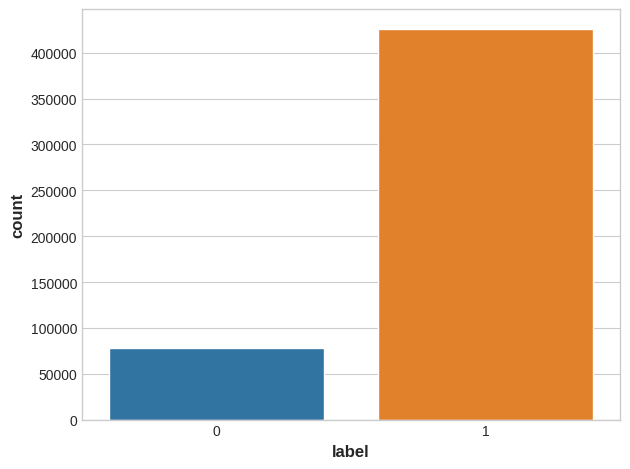

In [14]:
sns.countplot(x=data["label"])


# Balancing Data

In [15]:
datasetNeg , datasetPos, = (g for _,g in data.groupby('label'))

In [16]:
print(datasetNeg.shape)
datasetNeg.head()

(77565, 2)


,label,review
46,0,قرأتها من فترة طويلة و لا يحضرني فيها الا اعجا...
48,0,كان نفسي احب الرواية دي، أغلب اصدقائي اللي قرأ...
68,0,عملوا منها مسلسل. اجوف المسلسل ولا اقرى الرواي...
71,0,لطيفه :). كأنك بتتفرج ع مسلسل بس نوعا ما لطيف
73,0,الرواية جميلة تحمل معاني ورسالات كثيرة اراد ال...


In [17]:
print(datasetPos.shape)
datasetPos.head()

(426442, 2)


,label,review
0,1,صراع الجذور والانتماء، عقلة ساق الخيزان توائم ...
1,1,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...
2,1,رواية تلامس الروح بعمقها، فخورة اني اخيرا لقيت...
3,1,رواية محكمة بكل اختصار. وكان الجزء المفضل بالن...
4,1,هذا الكتاب يحزن مرا، ظلم واضطهاد عيسى بلا ذنب ...


In [18]:
datasetNeg = datasetNeg.iloc[0 :70000 ]
datasetPos = datasetPos.iloc[0 :80000 ]

In [19]:
data = pd.concat([datasetPos,datasetNeg])

In [20]:
print(data.shape)
data.head()

(150000, 2)


,label,review
0,1,صراع الجذور والانتماء، عقلة ساق الخيزان توائم ...
1,1,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...
2,1,رواية تلامس الروح بعمقها، فخورة اني اخيرا لقيت...
3,1,رواية محكمة بكل اختصار. وكان الجزء المفضل بالن...
4,1,هذا الكتاب يحزن مرا، ظلم واضطهاد عيسى بلا ذنب ...


In [21]:
data.label.value_counts()

1    80000
0    70000
Name: label, dtype: int64

In [22]:
stops = set(stopwords.words("arabic"))
stop_word_comp = {"،","آض","آمينَ","آه","آهاً","آي","أ","أب","أجل","أجمع","أخ","أخذ","أصبح","أضحى","أقبل","أقل","أكثر","ألا","أم","أما","أمامك","أمامكَ","أمسى","أمّا","أن","أنا","أنت","أنتم","أنتما","أنتن","أنتِ","أنشأ","أنّى","أو","أوشك","أولئك","أولئكم","أولاء","أولالك","أوّهْ","أي","أيا","أين","أينما","أيّ","أَنَّ","أََيُّ","أُفٍّ","إذ","إذا","إذاً","إذما","إذن","إلى","إليكم","إليكما","إليكنّ","إليكَ","إلَيْكَ","إلّا","إمّا","إن","إنّما","إي","إياك","إياكم","إياكما","إياكن","إيانا","إياه","إياها","إياهم","إياهما","إياهن","إياي","إيهٍ","إِنَّ","ا","ابتدأ","اثر","اجل","احد","اخرى","اخلولق","اذا","اربعة","ارتدّ","استحال","اطار","اعادة","اعلنت","اف","اكثر","اكد","الألاء","الألى","الا","الاخيرة","الان","الاول","الاولى","التى","التي","الثاني","الثانية","الذاتي","الذى","الذي","الذين","السابق","الف","اللائي","اللاتي","اللتان","اللتيا","اللتين","اللذان","اللذين","اللواتي","الماضي","المقبل","الوقت","الى","اليوم","اما","امام","امس","ان","انبرى","انقلب","انه","انها","او","اول","اي","ايار","ايام","ايضا","ب","بات","باسم","بان","بخٍ","برس","بسبب","بسّ","بشكل","بضع","بطآن","بعد","بعض","بك","بكم","بكما","بكن","بل","بلى","بما","بماذا","بمن","بن","بنا","به","بها","بي","بيد","بين","بَسْ","بَلْهَ","بِئْسَ","تانِ","تانِك","تبدّل","تجاه","تحوّل","تلقاء","تلك","تلكم","تلكما","تم","تينك","تَيْنِ","تِه","تِي","ثلاثة","ثم","ثمّ","ثمّة","ثُمَّ","جعل","جلل","جميع","جير","حار","حاشا","حاليا","حاي","حتى","حرى","حسب","حم","حوالى","حول","حيث","حيثما","حين","حيَّ","حَبَّذَا","حَتَّى","حَذارِ","خلا","خلال","دون","دونك","ذا","ذات","ذاك","ذانك","ذانِ","ذلك","ذلكم","ذلكما","ذلكن","ذو","ذوا","ذواتا","ذواتي","ذيت","ذينك","ذَيْنِ","ذِه","ذِي","راح","رجع","رويدك","ريث","رُبَّ","زيارة","سبحان","سرعان","سنة","سنوات","سوف","سوى","سَاءَ","سَاءَمَا","شبه","شخصا","شرع","شَتَّانَ","صار","صباح","صفر","صهٍ","صهْ","ضد","ضمن","طاق","طالما","طفق","طَق","ظلّ","عاد","عام","عاما","عامة","عدا","عدة","عدد","عدم","عسى","عشر","عشرة","علق","على","عليك","عليه","عليها","علًّ","عن","عند","عندما","عوض","عين","عَدَسْ","عَمَّا","غدا","غير","ـ","ف","فان","فلان","فو","فى","في","فيم","فيما","فيه","فيها","قال","قام","قبل","قد","قطّ","قلما","قوة","كأنّما","كأين","كأيّ","كأيّن","كاد","كان","كانت","كذا","كذلك","كرب","كل","كلا","كلاهما","كلتا","كلم","كليكما","كليهما","كلّما","كلَّا","كم","كما","كي","كيت","كيف","كيفما","كَأَنَّ","كِخ","لئن","لا","لات","لاسيما","لدن","لدى","لعمر","لقاء","لك","لكم","لكما","لكن","لكنَّما","لكي","لكيلا","للامم","لم","لما","لمّا","لن","لنا","له","لها","لو","لوكالة","لولا","لوما","لي","لَسْتَ","لَسْتُ","لَسْتُم","لَسْتُمَا","لَسْتُنَّ","لَسْتِ","لَسْنَ","لَعَلَّ","لَكِنَّ","لَيْتَ","لَيْسَ","لَيْسَا","لَيْسَتَا","لَيْسَتْ","لَيْسُوا","لَِسْنَا","ما","ماانفك","مابرح","مادام","ماذا","مازال","مافتئ","مايو","متى","مثل","مذ","مساء","مع","معاذ","مقابل","مكانكم","مكانكما","مكانكنّ","مكانَك","مليار","مليون","مما","ممن","من","منذ","منها","مه","مهما","مَنْ","مِن","نحن","نحو","نعم","نفس","نفسه","نهاية","نَخْ","نِعِمّا","نِعْمَ","ها","هاؤم","هاكَ","هاهنا","هبّ","هذا","هذه","هكذا","هل","هلمَّ","هلّا","هم","هما","هن","هنا","هناك","هنالك","هو","هي","هيا","هيت","هيّا","هَؤلاء","هَاتانِ","هَاتَيْنِ","هَاتِه","هَاتِي","هَجْ","هَذا","هَذانِ","هَذَيْنِ","هَذِه","هَذِي","هَيْهَاتَ","و","و6","وا","واحد","واضاف","واضافت","واكد","وان","واهاً","واوضح","وراءَك","وفي","وقال","وقالت","وقد","وقف","وكان","وكانت","ولا","ولم","ومن","مَن","وهو","وهي","ويكأنّ","وَيْ","وُشْكَانََ","يكون","يمكن","يوم","كان","ّأيّان"}

st = ISRIStemmer()
def stemNLTK(text):
    # tokenize
    zen = TextBlob(text)
    words = zen.words
    cleaned = list()
    for w in words:
        ty = st.stem(w)
        cleaned.append(ty)
    return " ".join(cleaned)


def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)


def remove_stop_words(text):
    zen = TextBlob(text)
    words = zen.words
    return " ".join([w for w in words if not w in stops and not w in stop_word_comp and len(w) >= 2])



def clean_text(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)  # remove punctuation
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    ## Convert text to lowercases
    text = text.lower()
    ## Remove stop words
    text = remove_stop_words(text)
    ## Remove numbers
    text = re.sub("\d+", " ", text)
    ## Remove Tashkeel
    #text = normalizeArabic(text)
    #text = re.sub('\W+', ' ', text)
    text = re.sub('[A-Za-z]+',' ',text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    #Stemming
    text = stemNLTK(text)
    return text

In [24]:
data['review'] = data['review'].apply(lambda x:clean_text(x))

# Split data

In [25]:
X = data['review']
y = data['label']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)


# KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer() 

In [29]:
knn_Classifier = KNeighborsClassifier(n_neighbors=7 , algorithm='auto')
from sklearn.pipeline import make_pipeline
knn_pipe=make_pipeline(vectorizer,knn_Classifier)
knn_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])

In [30]:
y_pred=knn_pipe.predict(X_test)
print(y_pred[1])

1


In [31]:
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(y_test,y_pred)

0.5622666666666667

In [32]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.08      0.15     14000
           1       0.55      0.98      0.71     16000

    accuracy                           0.56     30000
   macro avg       0.68      0.53      0.43     30000
weighted avg       0.67      0.56      0.44     30000



In [33]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

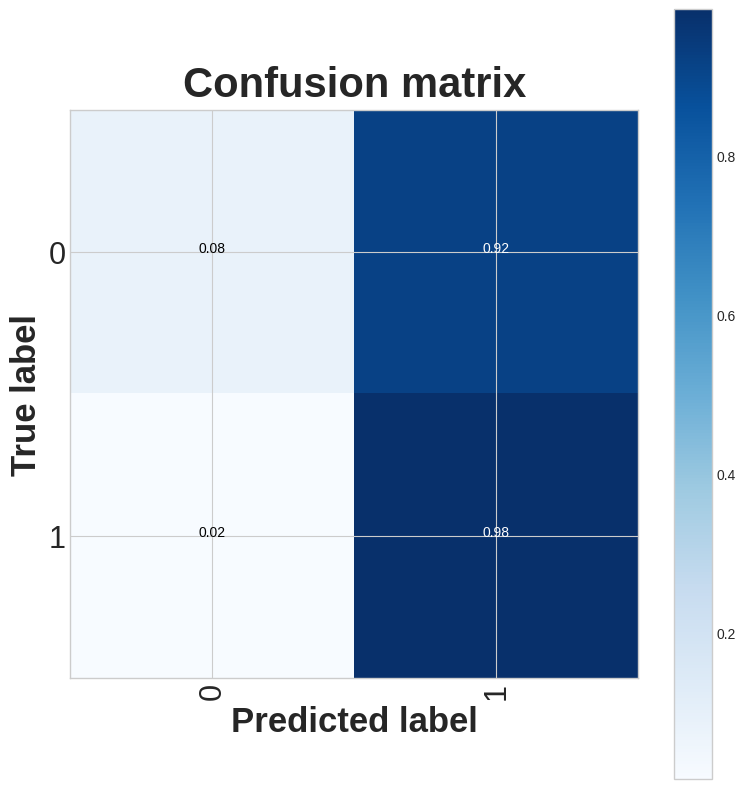

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes={0,1}, title="Confusion matrix")
plt.show()

# Logistic regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer() 
LR_Classifier = LogisticRegression()

lr_pipe=make_pipeline(vectorizer,LR_Classifier)
lr_pipe.fit(X_train,y_train)
lr_y_pred=lr_pipe.predict(X_test)

lr_y_pred[1]

1

In [38]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import accuracy_score,confusion_matrix

print("Accuracy score: " , accuracy_score(y_test,lr_y_pred))
print("Recall score: " ,recall_score(y_test,lr_y_pred))
print("Precision score: " ,precision_score(y_test,lr_y_pred))
print("F1 score: " ,f1_score(y_test,lr_y_pred))

Accuracy score:  0.8228666666666666
Recall score:  0.83925
Precision score:  0.8304267161410018
F1 score:  0.8348150450730494


In [39]:
from sklearn.metrics import classification_report
report = classification_report(y_test, lr_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.80      0.81     14000
           1       0.83      0.84      0.83     16000

    accuracy                           0.82     30000
   macro avg       0.82      0.82      0.82     30000
weighted avg       0.82      0.82      0.82     30000



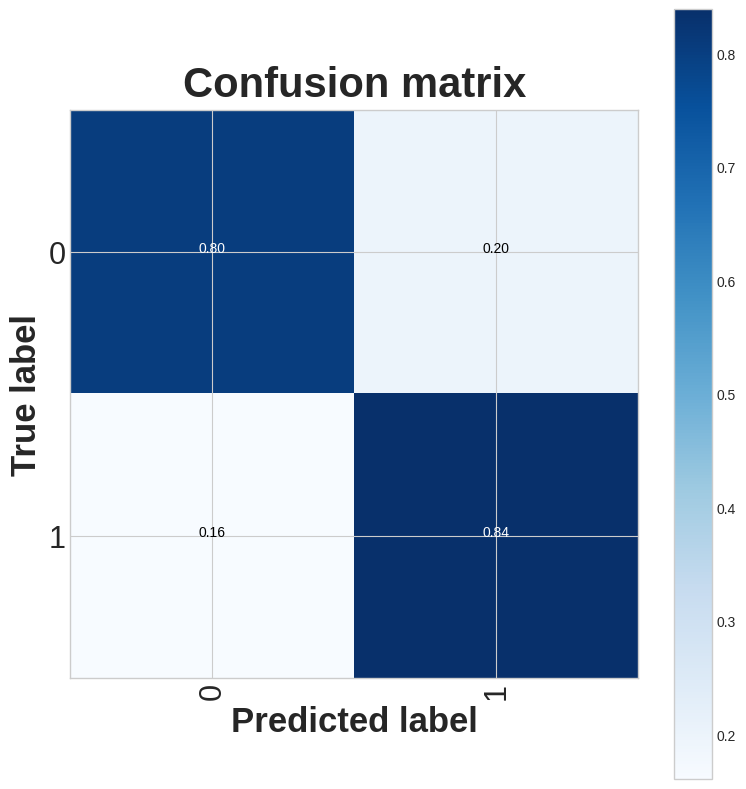

In [40]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cnf_matrix = confusion_matrix(y_test, lr_y_pred)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes={0,1}, title="Confusion matrix")
plt.show()

# Descision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.pipeline import make_pipeline

DT_Classifier = DecisionTreeClassifier(criterion="entropy")

DT_pipe=make_pipeline(vectorizer,DT_Classifier)
DT_pipe.fit(X_train,y_train)
DT_y_pred=DT_pipe.predict(X_test)

DT_y_pred[1]

1

In [42]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import accuracy_score,confusion_matrix

print("Accuracy score: " , accuracy_score(y_test,DT_y_pred))
print("Recall score: " ,recall_score(y_test,DT_y_pred))
print("Precision score: " ,precision_score(y_test,DT_y_pred))
print("F1 score: " ,f1_score(y_test,DT_y_pred))

Accuracy score:  0.6887
Recall score:  0.7146875
Precision score:  0.7054722684928126
F1 score:  0.7100499860287498


In [43]:
from sklearn.metrics import classification_report
report = classification_report(y_test, DT_y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.66      0.66     14000
           1       0.71      0.71      0.71     16000

    accuracy                           0.69     30000
   macro avg       0.69      0.69      0.69     30000
weighted avg       0.69      0.69      0.69     30000



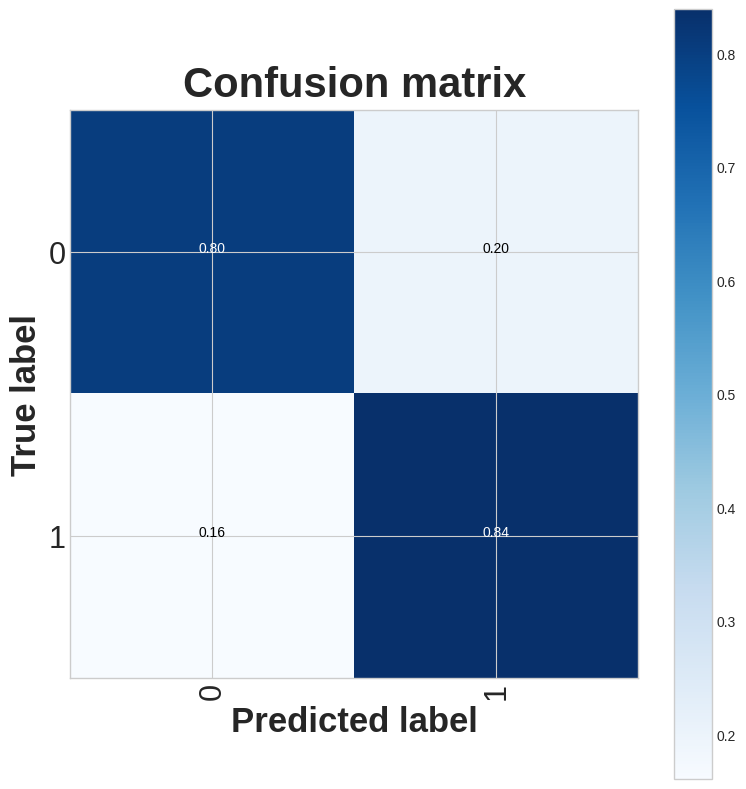

In [44]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cnf_matrix = confusion_matrix(y_test, lr_y_pred)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes={0,1}, title="Confusion matrix")
plt.show()